In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [3]:
from keras import backend as K
K.set_image_data_format('channels_last')

2024-08-12 15:59:13.227520: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-12 15:59:13.227916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-12 15:59:13.227925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


**PatchGAN Discriminator**

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    
    # Expand dimensions of source image to match target image
    #expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                          #output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    
    # Expand dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# define image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# create the model
model = define_discriminator(input_shape_2d, output_shape_3d)

# summarize the model
model.summary()


2024-08-12 15:59:47.704001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 15:59:50.763762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 15:59:50.764444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 15:59:50.766532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1,  0           ['input_1[0][0]']                
                                 1)                                                               
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 1,  0           ['lambda[0][0]']                 


/usr/local/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


                                 6)                                                               
                                                                                                  
 reshape (Reshape)              (None, 128, 128, 6)  0           ['lambda_1[0][0]']               
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 12  0           ['reshape[0][0]',                
                                )                                 'input_2[0][0]']                
                                                                                                  
 reshape_1

In [5]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
from tensorflow.keras.losses import Loss
from tensorflow.image import ssim
import tensorflow as tf

class SSIMLoss(Loss):
    def __init__(self, max_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.max_val = max_val

    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=self.max_val))

    def get_config(self):
        config = super().get_config()
        config.update({"max_val": self.max_val})
        return config

# Register the custom object
tf.keras.utils.get_custom_objects()['SSIMLoss'] = SSIMLoss



# U-Net Generator

In [7]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    #d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    #out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(optimizer='adam', loss=ssim_loss)
    return model

# define image shape
image_shape = (128, 128, 1)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1088        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 128)  131200      ['leaky_re_lu_5[0][0]']    

In [8]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(loss = ['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights = [1,100])
    return model

In [10]:
custom_objects = {'SSIMLoss': SSIMLoss}

In [11]:
# define image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# define the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 128, 128, 6)  41845382    ['input_7[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 8, 8, 1, 1)   27831233    ['input_7[0][0]',                
                                                                  'model_3[0][0]']                
                                                                                            

# Updating the model weights

In [12]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    # Check the dimensions of the dataset
    if dataset.shape != (500, 128, 128, 7):
        raise ValueError('Dataset dimensions do not match the expected shape ', dataset.shape)
    
    
    # Extract the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]

    # Extract the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]

    # Verify the shapes
    print("Brightfield images shape:", brightfield_images.shape)  # Should be (16338, 128, 128)
    print("Fluorescence images shape:", fluorescence_images.shape)  # Should be (16338, 128, 128, 6)

    return brightfield_images, fluorescence_images



In [13]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [14]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [15]:
def brightfield_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel6_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 6]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def normalization_process(image, min_val, max_val):
    image = (((image.astype(np.float32) - min_val) / (max_val - min_val)) * 65535).astype(np.float32)
    image = (image.astype(np.float32)/ 65535).astype(np.float32)
    return image

In [16]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf, images_dataset) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1, images_dataset) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2, images_dataset) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3, images_dataset) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4, images_dataset) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5, images_dataset) 
    minimum_value_6, maximum_value_6 =  channel6_images(minimum_value_6, maximum_value_6, images_dataset) 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==6):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_6)
                images_dataset[i, :, :, j] = temp_image
            
        

    
    
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    return images_dataset
    

In [17]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
                    
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)

In [18]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True



In [19]:
# Assuming you have already defined and created the gan_model
# Define the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
ssim_loss = SSIMLoss(max_val=1.0)
gan_model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1, 100])



In [20]:
import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

import os
import warnings
import numpy as np
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.monitor_op = np.less if mode == 'min' else np.greater
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            current = logs.get(self.monitor)
            if isinstance(current, list):
                current = current[0]  # Assuming the first value is what you want
            if current is None:
                warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
            else:
                if self.save_best_only:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {self.filepath}')
                        self.best = current
                        self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
                else:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: saving model to {self.filepath}')
                    self._save_model(self.filepath.format(epoch=epoch + 1, val_loss=current), overwrite=True)

    def _save_model(self, filepath, overwrite=True):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5', overwrite=overwrite)
            self.d_model.save_weights(filepath + '_discriminator.h5', overwrite=overwrite)
            self.gan_model.save_weights(filepath + '_gan.h5', overwrite=overwrite)
        else:
            self.g_model.save(filepath + '_generator.keras', overwrite=overwrite)
            self.d_model.save(filepath + '_discriminator.keras', overwrite=overwrite)
            self.gan_model.save(filepath + '_gan.keras', overwrite=overwrite)

In [21]:
import os
import shutil

"""
# Clear previous checkpoints
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)
"""

'\n# Clear previous checkpoints\ncheckpoint_dir = \'checkpoints\'\nif os.path.exists(checkpoint_dir):\n    print("checkpoint directory exists")\n    shutil.rmtree(checkpoint_dir)\nos.makedirs(checkpoint_dir)\n'

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [23]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

Found checkpoints:
Generator: checkpoints/model_checkpoint_40_10.55_generator.keras
Discriminator: checkpoints/model_checkpoint_40_10.55_discriminator.keras
GAN: checkpoints/model_checkpoint_40_10.55_gan.keras


In [24]:
input_shape_2d = (128, 128, 1)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 1)


In [25]:
import os
import tensorflow as tf

starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_2d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)

# Create the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=20
)


Loading weights from checkpoints...
Resuming from epoch 40
Weights loaded successfully.


In [26]:
flag = 0

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size, patch_shape, generator_model):
        
        self.file_path = file_path
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        
        self.data = np.load(file_path)['array']
        if(flag == 1):
            self.data = self.data[4000:4500]
        else:
            self.data = self.data[:2000]
        print(self.data.shape)
        self.data = normalization_of_images(self.data)

        self.indices = np.arange(self.data.shape[0])
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(self.data)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
    
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [28]:
import tensorflow as tf

def calculate_ssim_loss(real_images, generated_images):
    # Ensure the images are in the range [0, 1]
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    
    # Calculate SSIM scores
    ssim_scores = tf.image.ssim(real_images, generated_images, max_val=1.0)
    
    # Calculate mean SSIM score
    mean_ssim = tf.reduce_mean(ssim_scores)
    
    # Convert SSIM to loss (1 - SSIM)
    ssim_loss = 1 - mean_ssim
    
    return ssim_loss


In [29]:
import os

file_path = 'fluor_images_transposed_asnumpy.npz'
if os.path.exists(file_path):
    print(f"File found: {file_path}")
    data = np.load(file_path)
else:
    print(f"File not found: {file_path}")
    # Handle the error (e.g., exit the script or use a default dataset)

File found: fluor_images_transposed_asnumpy.npz


In [30]:
flag = 0

In [30]:
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data

data_gen = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)

(2000, 128, 128, 7)
minimum value in channel of brightfield images =  1072.0
maximum value in channel of brightfield images =  3368.0

minimum value in channel 1 of images =  38.0
maximum value in channel 1 of images =  788.0

minimum value in channel 2 of images =  45.0
maximum value in channel 2 of images =  956.0

minimum value in channel 3 of images =  34.0
maximum value in channel 3 of images =  784.0

minimum value in channel 4 of images =  28.0
maximum value in channel 4 of images =  595.0

minimum value in channel 5 of images =  63.0
maximum value in channel 5 of images =  702.0

minimum value in channel 6 of images =  13.0
maximum value in channel 6 of images =  317.0

shape of normalized images dataset =  (2000, 128, 128, 7)

Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)


In [32]:
[X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[1]

2024-08-10 18:00:53.043060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-10 18:00:53.699322: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-08-10 18:00:54.273470: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


In [34]:
print("X_realA: ", X_realA.shape)
print("X_realB", X_realB.shape)
print("X_fakeB", X_fakeB.shape)
print("y_real", y_real.shape)
print("y_fake", y_fake.shape)

X_realA:  (32, 128, 128)
X_realB (32, 128, 128, 6)
X_fakeB (32, 128, 128, 6)
y_real (32, 8, 8, 1)
y_fake (32, 8, 8, 1)


In [ ]:
# Assuming you have already defined and created the generator model (g_model)
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data
epochs = 50

data_gen = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)


# Training loop
for epoch in range(starting_epoch, epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        
        # Train the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Calculate SSIM loss
        ssim_loss = calculate_ssim_loss(X_realB, X_fakeB)
        
        print(f'Epoch {epoch+1}, Batch: {batch+1}, SSIM Loss: {ssim_loss}')
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
      
        
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})
    # Clear the Keras session
    tf.keras.backend.clear_session()

# Ensure to call on_train_end at the end of training
custom_checkpoint.on_train_end(logs={})

In [ ]:
plt.figure(figsize=(20, 20))
print(X_realB.shape)
for j in range(X_realB.shape[-1]):
    img = X_fakeB[5,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()

(32, 128, 128, 6)
0.030247102 0.07253188
0.027214931 0.09684418
0.026057888 0.10453315
0.0152830295 0.05601629
0.07981908 0.22014818
-0.007748975 0.02955995


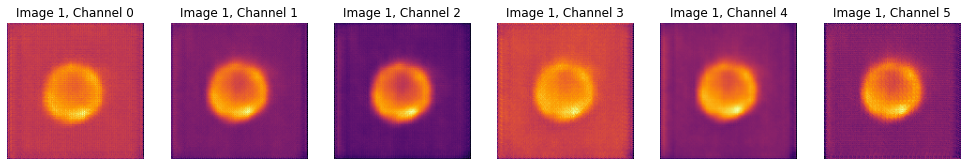

In [36]:

plt.figure(figsize=(20, 20))
print(X_fakeB.shape)
for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[5,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


In [31]:
flag = 1

In [32]:
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data


data_gen_validation = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)

d_losses_real = []
d_losses_fake = []
g_losses = []

(500, 128, 128, 7)
minimum value in channel of brightfield images =  1517.0
maximum value in channel of brightfield images =  3389.0

minimum value in channel 1 of images =  44.0
maximum value in channel 1 of images =  786.0

minimum value in channel 2 of images =  43.0
maximum value in channel 2 of images =  947.0

minimum value in channel 3 of images =  36.0
maximum value in channel 3 of images =  710.0

minimum value in channel 4 of images =  28.0
maximum value in channel 4 of images =  575.0

minimum value in channel 5 of images =  66.0
maximum value in channel 5 of images =  558.0

minimum value in channel 6 of images =  18.0
maximum value in channel 6 of images =  295.0

shape of normalized images dataset =  (500, 128, 128, 7)

Brightfield images shape: (500, 128, 128)
Fluorescence images shape: (500, 128, 128, 6)


In [33]:
[X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[1]

2024-08-12 16:01:14.422259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-12 16:01:54.304804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-08-12 16:02:53.551831: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 178s 178s/step


In [34]:
print("X_realA_val: ", X_realA_val.shape)
print("X_realB_val", X_realB_val.shape)
print("X_fakeB_val", X_fakeB_val.shape)
print("y_real_val", y_real_val.shape)
print("y_fake_val", y_fake_val.shape)


X_realA_val:  (32, 128, 128)
X_realB_val (32, 128, 128, 6)
X_fakeB_val (32, 128, 128, 6)
y_real_val (32, 8, 8, 1)
y_fake_val (32, 8, 8, 1)


In [35]:


for batch in range(0, len(data_gen_validation), batch_size):
    [X_realA_val, X_realB_val], [y_real_val, X_fakeB_val, y_fake_val] = data_gen_validation[batch]

    # Train the discriminator
    d_loss_real = d_model.test_on_batch([X_realA_val, X_realB_val], y_real_val)
    d_loss_fake = d_model.test_on_batch([X_realA_val, X_fakeB_val], y_fake_val)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_losses_real.append(d_loss_real)
    d_losses_fake.append(d_loss_fake)

    # Train the generator
    g_loss = gan_model.test_on_batch(X_realA_val, [y_real_val, X_realB_val])
    g_losses.append(g_loss)

    # Calculate SSIM loss
    ssim_loss = calculate_ssim_loss(X_realB_val, X_fakeB_val)

    print(f'Batch: {batch+1}, SSIM Loss: {ssim_loss}')
    print(f"Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
      
        
    
    # Clear the Keras session
    tf.keras.backend.clear_session()



1/1 [==============================] - 0s 22ms/step


2024-08-12 16:04:15.097639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/model_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Batch: 1, SSIM Loss: 0.28950703144073486
Batch: 1, D Loss Real: 0.10031623393297195, D Loss Fake: 1.791196584701538, G Loss: [29.164777755737305, 0.20724263787269592, 0.28957533836364746]


In [36]:
# Calculate average losses
avg_d_loss_real = np.mean(d_losses_real)
avg_d_loss_fake = np.mean(d_losses_fake)
avg_g_loss = np.mean(g_losses)

In [37]:
print(avg_d_loss_real)
print(avg_d_loss_fake)
print(avg_g_loss)

0.10031623393297195
1.791196584701538
9.887198577324549


(32, 128, 128, 6)
0.035284966 0.06682582
0.032646835 0.09621271
0.028218366 0.10191262
0.018620305 0.055827852
0.08932291 0.22016889
-0.01594035 0.03330198


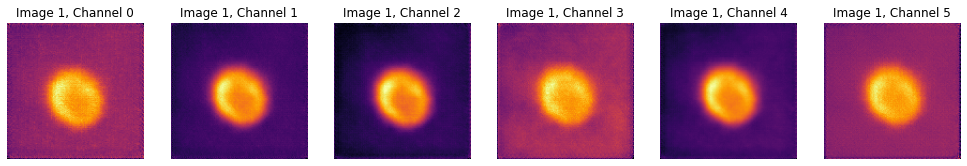

In [39]:
plt.figure(figsize=(20, 20))
print(X_fakeB_val.shape)
for j in range(X_fakeB_val.shape[-1]):
    img = X_fakeB_val[5,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()